In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams

import numpy as np

import spacy
nlp = spacy.load("en_core_web_sm")

import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
summary_prefs_ds = load_dataset('amang1802/summary_train')['test']

In [3]:
summary_prefs_ds

Dataset({
    features: ['info', 'summaries', 'choice', 'worker', 'batch', 'split', 'extra', 'query', 'tokens', 'generated_tokens', 'reward'],
    num_rows: 256
})

In [4]:
def df_from_id(i):
    text = summary_prefs_ds[i]['info']['post']
    choice = summary_prefs_ds[i]['choice']
    chosen = summary_prefs_ds[i]['summaries'][choice]['text']
    rejected = summary_prefs_ds[i]['summaries'][1-choice]['text']
    return pd.DataFrame({"text": [text], "chosen": [chosen], "rejected": [rejected]})

In [5]:
df_from_id(140)

,text,chosen,rejected
0,I've been on and off with this girl for the past 8 months. She lived with her ex boyfriend but insisted that the were broken up and she didn't want to be with him. He moved away from her 3 months ago and we've been casually seeing each other and having sex. \n\nThis weekend I went on a vacation with her and friends and found out that the ex had her listed as in a relationship on Facebook. When I found this out I messaged the ex and told him of all the times we had sex. I took screen shots of our conversation and told her to never talk to me again. She's since blocked me on Facebook and won't reply to my texts even though she agreed to talk to me about it. \n\nShe was a major part of my support system and I haven't been able to sleep well for 3 days. Does anyone have any advise how to break free from this depression?,"found out she was cheating on me messaged ex with proof that we've been seeing each other, now I'm depressed and need advise.",I'm super depressed and can't get a break from the relationship.


### What's the expected summary length?

Let's analyze the distribution of lengths of the chosen summaries

In [6]:
def word_count(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.is_alpha)

In [7]:
def word_count_chosen(row):
    choice = row['choice']
    chosen = row['summaries'][choice]['text']
    return {"word_count_chosen": word_count(chosen)}

In [8]:
summary_lengths_subset = summary_prefs_ds.map(word_count_chosen)

In [9]:
summary_lengths = np.array(summary_lengths_subset['word_count_chosen'])
print("Mean: ", summary_lengths.mean())
print("Std Dev: ", summary_lengths.std())

Mean:  26.61328125
Std Dev:  10.508314201545291


(array([14., 18., 45., 35., 30., 48., 24.,  7., 11.,  6.,  3.,  7.,  2.,
         1.,  1.,  0.,  3.,  0.,  0.,  1.]),
 array([10.  , 13.35, 16.7 , 20.05, 23.4 , 26.75, 30.1 , 33.45, 36.8 ,
        40.15, 43.5 , 46.85, 50.2 , 53.55, 56.9 , 60.25, 63.6 , 66.95,
        70.3 , 73.65, 77.  ]),
 <BarContainer object of 20 artists>)

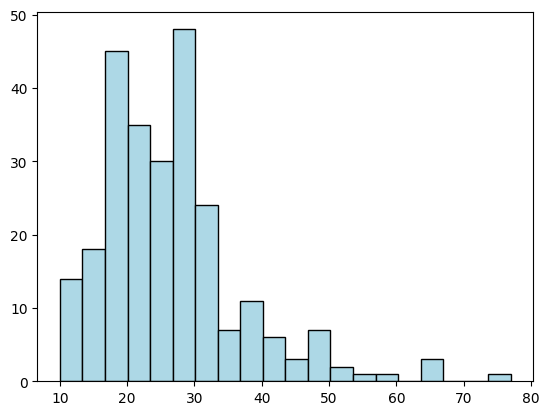

In [10]:
plt.hist(summary_lengths, color='lightblue', ec='black', bins=20)

### Model generated summary length distribution

In [11]:
model_id = "amang1802/Llama3.2-1B-summary-length-exp5"

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
llm = LLM(model=model_id, max_model_len=4096)

INFO 11-21 00:19:50 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='amang1802/Llama3.2-1B-summary-length-exp5', speculative_config=None, tokenizer='amang1802/Llama3.2-1B-summary-length-exp5', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=amang1802/Llama3.2-1B-summary-length-exp5, num_scheduler_steps=1, chunked_prefill_en

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 11-21 00:19:51 model_runner.py:1067] Loading model weights took 2.3185 GB
INFO 11-21 00:19:52 gpu_executor.py:122] # GPU blocks: 36191, # CPU blocks: 8192
INFO 11-21 00:19:52 gpu_executor.py:126] Maximum concurrency for 4096 tokens per request: 141.37x
INFO 11-21 00:19:54 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-21 00:19:54 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-21 00:20:02 model_runner.py:1523] Graph capturing finished in 9 secs.


In [13]:
def text_to_messages(info, target_words):
    return [
        {"role": "system", "content": f"Summarize the text using exactly {target_words} words:"},
        {"role": "user", "content": info['post']}
    ]
    
def summarize_batch(batch, llm, tokenizer, target_words):
    prompts = [tokenizer.apply_chat_template(text_to_messages(text, target_words), add_generation_prompt=True, tokenize=False)
               for text in batch]
    sampling_params = SamplingParams(temperature=0.25, max_tokens=128)
    outputs = llm.generate(prompts, sampling_params)

    return {"llm_summary": [output.outputs[0].text.strip() for output in outputs]}

In [14]:
gen_summaries = summary_lengths_subset.map(lambda batch: summarize_batch(batch, llm, tokenizer, 31),
                                           input_columns=['info'],
                                           batched=True,
                                           batch_size=256)

Parameter 'function'=<function <lambda> at 0x7f80e475cfe0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/256 [00:00<?, ? examples/s]


Processed prompts:   0%|         | 0/256 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]
Processed prompts:   0%| | 1/256 [00:03<13:27,  3.17s/it, est. speed input: 55.88 toks/s, output: 2.53 toks/s
Processed prompts:   2%| | 6/256 [00:03<01:46,  2.35it/s, est. speed input: 524.02 toks/s, output: 17.17 toks
Processed prompts:   6%| | 15/256 [00:03<00:33,  7.14it/s, est. speed input: 1322.31 toks/s, output: 64.90 to
Processed prompts:  12%| | 30/256 [00:03<00:12, 17.46it/s, est. speed input: 2583.45 toks/s, output: 158.71 t
Processed prompts:  27%|▎| 70/256 [00:03<00:03, 52.45it/s, est. speed input: 6178.39 toks/s, output: 445.96 t
Processed prompts:  64%|▋| 165/256 [00:03<00:00, 156.04it/s, est. speed input: 14503.40 toks/s, output: 1262.
Processed prompts: 100%|█| 256/256 [00:04<00:00, 58.81it/s, est. speed input: 20066.83 toks/s, output: 2193.6


In [15]:
gen_summaries['llm_summary'][:5]

["You're concerned about your friend's behavior, feeling uncomfortable with his skewed views on sex, and want to confront him.",
 "The writer is unsure how to interpret the woman's openness, wondering if she's trying to be one of the guys or if she's genuinely interested in exploring a romantic or sexual connection.",
 "You're feeling guilty about missing your mom's party, worried about being awkward, and unsure about attending your first party.",
 'Repeated calls from a patient at a special needs institute, breathing for 2 seconds, with no response, leaving frustration and a sense of helplessness, despite efforts to block numbers.',
 "The girlfriend's comment about IV TAs raises concerns about her intentions, potentially hinting she's drunk and seeking physical intimacy."]

In [16]:
def word_count_text(text, name):
    return {f"word_count_{name}": word_count(text)}

In [17]:
gen_summaries = gen_summaries.map(lambda text: word_count_text(text, "llama-1b-31"), input_columns=['llm_summary'])

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

In [18]:
summary_lengths = np.array(gen_summaries['word_count_llama-1b-31'])
print("Mean: ", summary_lengths.mean())
print("Std Dev: ", summary_lengths.std())

Mean:  28.80859375
Std Dev:  13.597107501136444


(array([ 5.,  6., 27., 38., 84., 47., 22.,  7.,  6.,  5.,  0.,  0.,  0.,
         2.,  0.,  1.,  0.,  1.,  3.,  2.]),
 array([  5.  ,   9.75,  14.5 ,  19.25,  24.  ,  28.75,  33.5 ,  38.25,
         43.  ,  47.75,  52.5 ,  57.25,  62.  ,  66.75,  71.5 ,  76.25,
         81.  ,  85.75,  90.5 ,  95.25, 100.  ]),
 <BarContainer object of 20 artists>)

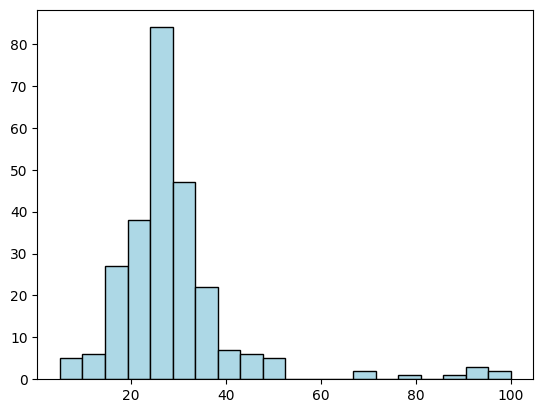

In [19]:
plt.hist(summary_lengths, color='lightblue', ec='black', bins=20)